In [ ]:
import sys
sys.path.insert(0, './src/')

import nwq2qis
from nwq2qis import *

##
import numpy as np
import qiskit
import qiskit.quantum_info as qi
from qiskit_nature.second_q.mappers import JordanWignerMapper, InterleavedQubitMapper
from _gcim_utilis import parse_hamiltonian
import scipy.sparse.linalg as ssl
import scipy.linalg as sl
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import json
from qiskit_ibm_runtime import RuntimeEncoder
from qiskit.primitives import StatevectorEstimator
##

n_orb = 6
n_a = 3
n_b = 3
ducc_lvl = 3
results_file = '../Qubit-ADAPT-VQE/printout_qubit_bztz66ducc3.txt'
output_folder = 'Example_Outputs/Benzene'  ## Please create this folder before you run the code
noise_factors = [1,3,5,7,9]
selected_iter = 3 ## which qubit-adapt-vqe iteration, start from 0

mol_name =  f'Benzene{n_a+n_b}{n_orb}DUCC{ducc_lvl}'
file_path = "../Benzene/cc-pVTZ/FrozenCoreCCSD_6Elec_6Orbs/DUCC3/benzene-FC-CCSD-6Electrons-6Orbitals.out-xacc"

print("  - Number of electrons:", n_a + n_b)
print("  - Number of orbitals:", n_orb)
print("  - DUCC:", ducc_lvl)
print("  - Target molecule:", mol_name)
print("  - Input file:", file_path)

fermi_ham = parse_hamiltonian(file_path, n_orb, interleaved=False, return_type = 'qiskit')
nwqsim_dict = extract_nwqsim_output(results_file, inverse_pauli=False)

mapper = JordanWignerMapper()
qubit_op = mapper.map(fermi_ham)

true_eigvals = sl.eigh(qubit_op.to_matrix(sparse=False))[0]

errors = np.abs( np.array(nwqsim_dict['energies']) - true_eigvals[0] )
for i, error in enumerate(errors):
    print(f"{i}:  {str(nwqsim_dict['operators'][i].paulis[0])}   {error}")

  - Number of electrons: 6
  - Number of orbitals: 6
  - DUCC: 3
  - Target molecule: Benzene66DUCC3
  - Input file: Input_Data/bztz66ducc3.hamil
0:  IIXYIIIIXXII   0.01348839370098176
1:  IXZZYIIXZZXI   0.009069664416131218
2:  IXYYYIIIIIII   0.006903987496770014
3:  IIIIIIIXYYYI   0.004627837152099801
4:  IIXZYIIXZXII   0.003211208184438874
5:  IXZYIIIIYZYI   0.00166337549356399
6:  IXZYIIIYZYII   0.0009027892702135887
7:  IIXZYIIIXZXI   5.9706986633045744e-05
8:  XZZZZYXZZZZX   4.0131389056341504e-05
9:  IXZZZYIXZZZX   1.966874268077845e-05
10:  IIXZZYIIYZZY   8.206699789070626e-06
11:  XZZZYIYZZZYI   6.411619068558139e-06
12:  XZZYIIXZZXII   4.660084869101411e-06
13:  IXZZXIIIXYII   2.523685765254413e-06
14:  IIXXIIIYZZXI   1.8891761328632128e-06
15:  IYZZZYIXZZZY   1.812046463101069e-06
16:  IXZZZYIYZZZY   1.5580914123347611e-06
17:  IIYZZYIIYZZX   1.2352645057944756e-06


## CHOP Hamiltonian

In [ ]:
## remove values that too small
np.set_printoptions(suppress=True)
shot_factor = 5000 ## Seem like 5000 is a sweet spot for accuracy

## Compute sum of coefficients
pas, cas = pauli_coeff_separation(qubit_op)
ck_abs = np.abs(cas[1:]) ## 1st term is too large
ck_sum = np.linalg.norm(ck_abs, ord=1)
chop_thresh =  ck_sum / shot_factor
print(chop_thresh)
# chop_thresh = 1e-5
qubit_op_chopped = qubit_op.chop(chop_thresh)
print(f"Chopped/unchopped # of Pauli strings  = {len(qubit_op_chopped)}/{len(qubit_op)}")

# ##
pas_ch, cas_ch = pauli_coeff_separation(qubit_op_chopped)

0.0011622583164849999
Chopped/unchopped # of Pauli strings  = 143/371


## Optimize Parameters

In [ ]:
vqe_circ, symbol_params = create_vqe_circ(nwqsim_dict['operators'][:selected_iter+1], 
                                            n_orb*2, n_a+n_b, interleaved=False, half_barriar=True)

## Optimize parameters
def cost_func(parameters):
    """Compute the energy for given parameters."""
    estimator = StatevectorEstimator()
    job = estimator.run([(vqe_circ, qubit_op_chopped, parameters)])
    return float( job.result()[0].data.evs )

num_vars = len(nwqsim_dict['parameters'][:selected_iter+1])
optimizer = COBYLA(maxiter=5000, disp=True)
result = optimizer.minimize(cost_func, nwqsim_dict['parameters'][:selected_iter+1])

pre_opt_params = result.x

basis_gates = ['u', 'cx']
trans_vqe_opt = transpile(vqe_circ.assign_parameters(pre_opt_params), basis_gates=basis_gates, 
                          optimization_level=2, seed_transpiler=7)
print(trans_vqe_opt.count_ops(), cost_func(pre_opt_params), nwqsim_dict['energies'][selected_iter])

np.save(f"{output_folder}/optparam-vqe-itr{selected_iter}.npy", pre_opt_params)
pre_opt_params

OrderedDict({'u': 38, 'cx': 32, 'barrier': 1}) -231.78285106460956 -231.78315431138677


array([-0.60850649, -0.61062285, -0.4551916 , -0.45515626])

## Group Pauli Operators and Generate Circuits

In [5]:
import nwq2qis
import importlib
importlib.reload(nwq2qis)
from nwq2qis import *

pauli_dict, coeff_dict = grouped_pauli_in_dict(qubit_op_chopped, use_qwc=True) ## grouping paulis in the Hamiltonian and separate Pauli strings and Coefficients
circ_dict = commuting_circs(list(pauli_dict.keys()), trans_vqe_opt, add_measure = True, noise_factors=noise_factors, inverse_pauli = False, noise_type='half') ## Form circuits for each commuting group
circ_dict_nomeasure = commuting_circs(list(pauli_dict.keys()), trans_vqe_opt, add_measure = False, noise_factors=noise_factors, inverse_pauli = False, noise_type='half') ## Form circuits for each commuting group
print("Number of commuting groups:",len(list(pauli_dict.keys())))
print(f"Total number of cx gates: {trans_vqe_opt.count_ops()['cx']*len(list(pauli_dict.keys()))}")

## Exact Solutions
theo_state = qi.Statevector.from_instruction(vqe_circ.assign_parameters(pre_opt_params)) ## exact state
theo_energy = theo_state.expectation_value(qubit_op_chopped).real
print(theo_energy)

Number of commuting groups: 39
Total number of cx gates: 1248
-231.78285106460956


## Infinite Shots

In [ ]:
for nf in noise_factors:
    print(f"\nNoise factor: {nf}")
    meas_prob_dict_ideal = {}
    cx_count = 0
    for key, circs in circ_dict_nomeasure.items():
        circ = circs[int((nf-1)/2)]
        cx_count += circ.count_ops()['cx']
        meas_prob_dict_ideal[key] = qiskit_normal_order_switch_vec( qi.Statevector.from_instruction(circ).probabilities(decimals=16)  )

    final_exp_ideal = est_exp_sampler(pauli_dict, coeff_dict, meas_prob_dict_ideal, debug_state = theo_state) ## compute the expectation value and sum them up
    print(f"  Number of cx gates: {cx_count}")
    print(f"  Final expectation energy: {final_exp_ideal}, Error to qiskit {abs(theo_energy - final_exp_ideal)}, Error to full Ham ideal {abs(final_exp_ideal-nwqsim_dict['energies'][selected_iter])}")


Noise factor: 1
  Number of cx gates: 1248
  Final expectation energy: -231.7828510646102, Error to qiskit 6.536993168992922e-13, Error to full Ham ideal 0.00030324677655357846

Noise factor: 3
  Number of cx gates: 2184
  Final expectation energy: -231.7828510646102, Error to qiskit 6.536993168992922e-13, Error to full Ham ideal 0.00030324677655357846

Noise factor: 5
  Number of cx gates: 3120
  Final expectation energy: -231.7828510646102, Error to qiskit 6.536993168992922e-13, Error to full Ham ideal 0.00030324677655357846

Noise factor: 7
  Number of cx gates: 4056
  Final expectation energy: -231.7828510646102, Error to qiskit 6.536993168992922e-13, Error to full Ham ideal 0.00030324677655357846

Noise factor: 9
  Number of cx gates: 4992
  Final expectation energy: -231.7828510646102, Error to qiskit 6.536993168992922e-13, Error to full Ham ideal 0.00030324677655357846


In [7]:
final_exp_ideal - true_eigvals[0]

0.004931083928653379

## Finite Sampler

In [8]:
from qiskit.primitives import StatevectorSampler
sampler = StatevectorSampler()

total_shots_used = 0
for nf in noise_factors:
# for nf in [1]:
    print(f"\nNoise factor: {nf}")
    meas_prob_dict_finitesim = {}
    cx_count = 0
    circ_counter = 0
    for key, circs in circ_dict.items():
        total_shots_used += 1024
        temp_circ = circs[int((nf-1)/2)]
        cx_count += temp_circ.count_ops()['cx'] ## 
        meas_quasi_res = sampler.run([temp_circ], shots=1024).result()[0].data.meas.get_counts()
        meas_prob_dict_finitesim[key] = freq_dict_to_prob_array(meas_quasi_res, len(key), endien_switch = True)
        circ_counter += 1

    final_exp_finitesim = est_exp_sampler(pauli_dict, coeff_dict, meas_prob_dict_finitesim) ## compute the expectation value and sum them up
    print(f"  Number of cx gates: {cx_count}")
    print(f"  Final expectation energy: {final_exp_finitesim}, Error to qiskit {abs(theo_energy - final_exp_finitesim)}, Error to full Ham ideal {abs(final_exp_finitesim-nwqsim_dict['energies'][selected_iter])}")


Noise factor: 1
  Number of cx gates: 1248
  Final expectation energy: -231.79037129062348, Error to qiskit 0.007520226013923548, Error to full Ham ideal 0.00721697923671627

Noise factor: 3
  Number of cx gates: 2184
  Final expectation energy: -231.78993213443817, Error to qiskit 0.007081069828615227, Error to full Ham ideal 0.00677782305140795

Noise factor: 5
  Number of cx gates: 3120
  Final expectation energy: -231.7860720792147, Error to qiskit 0.003221014605145456, Error to full Ham ideal 0.002917767827938178

Noise factor: 7
  Number of cx gates: 4056
  Final expectation energy: -231.78262120059503, Error to qiskit 0.00022986401452840255, Error to full Ham ideal 0.0005331107917356803

Noise factor: 9
  Number of cx gates: 4992
  Final expectation energy: -231.77975853112366, Error to qiskit 0.003092533485897775, Error to full Ham ideal 0.0033957802631050527


In [9]:
final_exp_finitesim - true_eigvals[0], final_exp_ideal - true_eigvals[0]

(0.008023617415204853, 0.004931083928653379)

In [10]:
errors[selected_iter], nwqsim_dict['energies'][selected_iter]

(0.004627837152099801, -231.78315431138677)

## To Quantinuum circuit

In [ ]:
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit
import qnexus as qnx
import datetime
# qnx.login()

project = qnx.projects.get_or_create("VQE BZ TZ nf 13579 Simu CX Half ZNE")
qnx.context.set_active_project(project)
name_suffix = f'itr{selected_iter}'
config = qnx.QuantinuumConfig(device_name="H1-Emulator")

job_path = pathlib.Path(f'{output_folder}/itr{selected_iter}_job')
job_path.mkdir(parents=True, exist_ok=True) 

qnx.quotas.get_all().df()

,name,description,usage,quota
0,jupyterhub,"Total Jupyterhub notebook server running time,...",11120.000000,No quota set for user
1,database_usage,Total megabytes used to store scientific data.,59.047499,No quota set for user
2,compilation,"Total CPU running time, in seconds.",137.255128,No quota set for user
3,simulation,"Total CPU running time, in seconds.",3706.058125,No quota set for user


In [ ]:
qtm_pauli_arr = []
qtm_circ_arr = []

for key, circs in circ_dict.items():
    for nf in noise_factors:
        circ = circs[int((nf-1)/2)]
        pname = f"{key}-{nf}"
        qtm_c = qiskit_to_tk(circ)
        ref_circuit = qnx.circuits.upload(
            circuit=qtm_c, 
            name=f"{pname}-{name_suffix}", 
        )
        qtm_pauli_arr.append(pname)
        qtm_circ_arr.append(ref_circuit)


ref_compile_job = qnx.start_compile_job(
    circuits=qtm_circ_arr,
    optimisation_level=0,
    backend_config=config,
    name=f"vqe-{name_suffix}"
)

print(ref_compile_job.annotations.name)
print(f"{job_path}/paulikey-{ref_compile_job.annotations.name}.npy")
np.save(f"{job_path}/paulikey-{ref_compile_job.annotations.name}.npy", qtm_pauli_arr)

print(ref_compile_job)

vqe-itr3
TZChop_Outputs_CXHalfZNE_Test_Longer/itr3_job/paulikey-vqe-itr3.npy
id=UUID('d1a5f2e2-d614-4060-8e76-5e1cac264822') annotations=Annotations(name='vqe-itr3', description='', properties=OrderedDict(), created=datetime.datetime(2025, 5, 29, 23, 54, 50, 399468, tzinfo=TzInfo(UTC)), modified=datetime.datetime(2025, 5, 29, 23, 54, 50, 399468, tzinfo=TzInfo(UTC))) job_type=<JobType.COMPILE: 'compile'> last_status=<StatusEnum.SUBMITTED: 'Circuit has been submitted.'> last_message='' project=ProjectRef(id=UUID('fa6fc156-c0ad-4252-9303-8cda69f0139c'), annotations=Annotations(name='VQE BZ TZ nf 13579 Simu CX Half ZNE', description=None, properties=OrderedDict(), created=datetime.datetime(2025, 5, 29, 23, 54, 18, 982430, tzinfo=TzInfo(UTC)), modified=datetime.datetime(2025, 5, 29, 23, 54, 18, 982430, tzinfo=TzInfo(UTC))), contents_modified=datetime.datetime(2025, 5, 29, 23, 54, 18, 986955, tzinfo=TzInfo(UTC)), archived=False, type='ProjectRef') type='CompileJobRef'


In [17]:
from pathlib import Path
qnx.filesystem.save(
    ref=ref_compile_job,
    path=Path.cwd() / job_path / f"job-ref_comp-{ref_compile_job.annotations.name}",
    mkdir=True,
)

In [18]:
ref_job_name = f"vqe-itr{selected_iter}"
ref_compile_job = qnx.filesystem.load(
    path=Path.cwd() / job_path / f"job-ref_comp-{ref_job_name}",
)
ref_compile_job

CompileJobRef(id=UUID('d1a5f2e2-d614-4060-8e76-5e1cac264822'), annotations=Annotations(name='vqe-itr3', description='', properties=OrderedDict(), created=datetime.datetime(2025, 5, 29, 23, 54, 50, 399468, tzinfo=TzInfo(UTC)), modified=datetime.datetime(2025, 5, 29, 23, 54, 50, 399468, tzinfo=TzInfo(UTC))), job_type=<JobType.COMPILE: 'compile'>, last_status=<StatusEnum.SUBMITTED: 'Circuit has been submitted.'>, last_message='', project=ProjectRef(id=UUID('fa6fc156-c0ad-4252-9303-8cda69f0139c'), annotations=Annotations(name='VQE BZ TZ nf 13579 Simu CX Half ZNE', description=None, properties=OrderedDict(), created=datetime.datetime(2025, 5, 29, 23, 54, 18, 982430, tzinfo=TzInfo(UTC)), modified=datetime.datetime(2025, 5, 29, 23, 54, 18, 982430, tzinfo=TzInfo(UTC))), contents_modified=datetime.datetime(2025, 5, 29, 23, 54, 18, 986955, tzinfo=TzInfo(UTC)), archived=False, type='ProjectRef'), type='CompileJobRef')

## Estimate costs

In [19]:
ref_compiled_job_arr = [item for item in qnx.jobs.results(ref_compile_job)]
ref_compiled_circuits = [item.get_output() for item in ref_compiled_job_arr]
downloaded_circuits = [item.download_circuit() for item in ref_compiled_circuits]
ref_compiled_job_arr[0].df()

,name,description,created,modified,project,id
0,ZYZZZYZYZZZY-1-itr3-compilation,,2025-05-29 23:55:30.990471+00:00,2025-05-29 23:55:31.001328+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,385b56f9-b6e8-450b-983d-7e40d423e04f


In [20]:
qtm_qis_circs = [tk_to_qiskit(dc) for dc in downloaded_circuits]
qtm_qis_rzzs = [dc.count_ops()['rzz'] for dc in qtm_qis_circs]
np.save(f"{job_path}/rzzcount-{ref_compile_job.annotations.name}.npy", qtm_qis_rzzs)
print(np.mean(qtm_qis_rzzs))

80.0


## Submit to execute

In [23]:
shots = 1024
execute_job_ref = qnx.start_execute_job(
    circuits=ref_compiled_circuits,
    name=f"{ref_job_name}_{shots}shots",
    n_shots=[shots]* len(ref_compiled_circuits),
    backend_config=qnx.QuantinuumConfig(device_name="H1-1E"),
    project=project,
)

print(execute_job_ref.annotations.name)

vqe-itr3_1024shots


In [24]:
# Retrieve a ExecutionResultRef for every Circuit that was run
execute_job_result_refs = qnx.jobs.results(execute_job_ref)

from pathlib import Path
qnx.filesystem.save(
    ref=execute_job_ref,
    path=Path.cwd() / job_path / f"job-exec-{execute_job_ref.annotations.name}",
    mkdir=True,
)

execute_job_result_refs.df()

,name,description,created,modified,project,id
0,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,0f60b023-3ff8-416e-8ab8-892971c3535f
1,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,44bd8b41-2b95-4617-9dd8-ef8fef79427f
2,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,ea8b5e3f-53be-4650-8a6c-3bdeb80ddc6e
3,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,7bacd631-dd67-4950-b642-fb145d49ef54
4,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,a6f365a7-ce4c-40ec-87c6-5aec35c8f735
...,...,...,...,...,...,...
190,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,58f83ed1-3786-4661-a081-7f56d6c39b35
191,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,5e0f1ddb-08b4-44f8-87e1-34550af9b23c
192,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,5bfd058f-89fb-488b-a7e2-149abc435af8
193,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,a314ee3d-f4fd-4a13-abba-086752ddab7e


In [25]:
from pathlib import Path

exec_job_name = f"vqe-itr{selected_iter}_{shots}shots"
execute_job_ref = qnx.filesystem.load(
    path=Path.cwd() / job_path / f"job-exec-{exec_job_name}",
)

qtm_pauli_arr = np.load(f"{job_path}/paulikey-{exec_job_name.split('_')[0]}.npy")
execute_job_result_refs = qnx.jobs.results(execute_job_ref)
execute_job_result_refs.df()

,name,description,created,modified,project,id
0,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,0f60b023-3ff8-416e-8ab8-892971c3535f
1,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,44bd8b41-2b95-4617-9dd8-ef8fef79427f
2,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,ea8b5e3f-53be-4650-8a6c-3bdeb80ddc6e
3,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,7bacd631-dd67-4950-b642-fb145d49ef54
4,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,a6f365a7-ce4c-40ec-87c6-5aec35c8f735
...,...,...,...,...,...,...
190,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,58f83ed1-3786-4661-a081-7f56d6c39b35
191,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,5e0f1ddb-08b4-44f8-87e1-34550af9b23c
192,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,5bfd058f-89fb-488b-a7e2-149abc435af8
193,vqe-itr3_1024shots,,2025-05-30 00:28:47.117097+00:00,2025-05-30 00:28:47.117097+00:00,VQE BZ TZ nf 13579 Simu CX Half ZNE,a314ee3d-f4fd-4a13-abba-086752ddab7e


In [26]:
# noise_factors = [1,3,5]
qtm_results = { str(nf):{} for nf in noise_factors}
for ps, res_ref in zip(qtm_pauli_arr, execute_job_result_refs):
    pauli_str, nf = ps.split('-')
    qtm_results[nf][pauli_str] = freq_dict_to_prob_array( res_ref.download_result().get_counts(), len(pauli_str), endien_switch = False)
# np.array(qtm_results['1'][qtm_pauli_arr[0].split('-')[0]])

In [29]:
qtm_exps = []
qtm_vars = []
# noise_factors = [1,3,5]
for nf in noise_factors:
    print(f"\nNoise factor: {nf}")
    final_exp_qtmh1,final_var_qtmh1 = est_exp_sampler(pauli_dict, coeff_dict, qtm_results[str(nf)], return_var=True, num_shots=1024) ## compute the expectation value and sum them up
    qtm_exps.append(final_exp_qtmh1)
    qtm_vars.append(final_var_qtmh1)
    print(f"  Estimation {final_exp_qtmh1} +- {np.sqrt(final_var_qtmh1)}, Error to qiskit {abs(theo_energy - final_exp_qtmh1)}, Error to FCI {abs(final_exp_qtmh1 - true_eigvals[0])}, Error to full Ham ideal {abs(final_exp_finitesim-nwqsim_dict['energies'][selected_iter])}, finite-sampling error {1/np.sqrt(shots)}")


Noise factor: 1
  Estimation -231.74079723872356 +- 0.006797616537022529, Error to qiskit 0.042053825886000595, Error to FCI 0.046984909815307674, Error to full Ham ideal 0.0033957802631050527, finite-sampling error 0.03125

Noise factor: 3
  Estimation -231.72431702809538 +- 0.007809222671165723, Error to qiskit 0.05853403651417466, Error to FCI 0.06346512044348174, Error to full Ham ideal 0.0033957802631050527, finite-sampling error 0.03125

Noise factor: 5
  Estimation -231.68881358656697 +- 0.008849254629015599, Error to qiskit 0.0940374780425941, Error to FCI 0.09896856197190118, Error to full Ham ideal 0.0033957802631050527, finite-sampling error 0.03125

Noise factor: 7
  Estimation -231.675521722854 +- 0.00968253521454442, Error to qiskit 0.10732934175555897, Error to FCI 0.11226042568486605, Error to full Ham ideal 0.0033957802631050527, finite-sampling error 0.03125

Noise factor: 9
  Estimation -231.65264613083355 +- 0.010557538586974793, Error to qiskit 0.13020493377601383

In [30]:
np.set_printoptions(suppress=True)
qtm_vars

[4.6207590584402156e-05,
 6.098395872784871e-05,
 7.8309307489154e-05,
 9.375148818089275e-05,
 0.00011146162101546173]

R^2 value: 0.9822730968517734


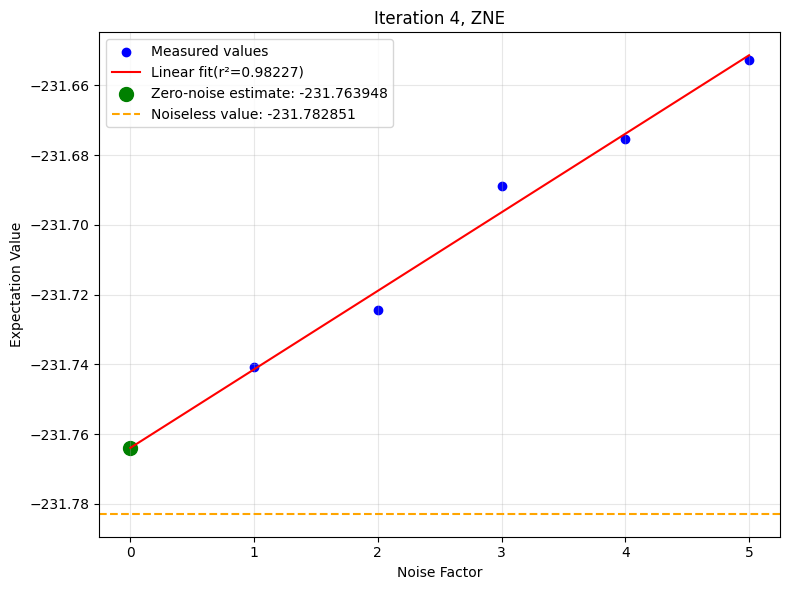

In [47]:
# for nf in noise_factors:
#     np.save(f"{job_path}/zneexp-{exec_job_name}_nf{nf}.npy", list(qtm_exps))


import nwq2qis
import importlib
importlib.reload(nwq2qis)
from nwq2qis import *
noise_factors_half = [1,2,3,4,5]
ex_exp, popt = extrapolate_to_zero_noise(noise_factors_half, qtm_exps, extrapolation_method='linear', 
                                   plot=True, plot_title=f"Iteration {selected_iter+1}, ZNE",
                                   plot_horizontal_line=theo_energy,
                                   plot_horizontal_line_legend="Noiseless value")
np.save(f"{job_path}/zneexp-{exec_job_name}.npy", [ex_exp]+list(qtm_exps))
np.save(f"{job_path}/znepopt-{exec_job_name}.npy", popt)

In [46]:
intercept_with_uncertainty(noise_factors_half, qtm_exps, alpha=0.05)

{'intercept': -231.76394839772107,
 'intercept_se': 0.0057903756390460465,
 'uncertainty': 0.018427559558690094,
 'CI': (-231.78237595727975, -231.74552083816238)}

In [42]:
qtm_exps

[-231.74079723872356,
 -231.72431702809538,
 -231.68881358656697,
 -231.675521722854,
 -231.65264613083355]

In [43]:
ex_exp, theo_energy, true_eigvals[0], abs(ex_exp - true_eigvals[0]),abs(theo_energy - true_eigvals[0]),

(-231.76394839772115,
 -231.78285106460956,
 -231.78778214853887,
 0.023833750817715327,
 0.0049310839293070785)

In [36]:
abs(ex_exp - true_eigvals[0]), abs(theo_energy - ex_exp),  1/np.sqrt(1024)

(0.023833750817715327, 0.01890266688840825, 0.03125)